# Probable Maximum Precipitation (PMP) module

This example shows how to use the PMP module to compute the Probable Maximum Precipitation from climate change scenarios.  This module allows to compute the PMP for each individual pixel on a grid and for aggregated values of precipitation following the methodology shown by Clavet-Gaumont et al. (2017). DOI: https://doi.org/10.1016/j.ejrh.2017.07.003.

In [1]:
from pathlib import Path
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from xhydro import pmp
from xhydro.testing.helpers import deveraux

## Open data 

This example uses a sample of 2-years and 3x3 grid cells from the CMIP model which can be accessed from the xhydro-testdata repository. It should be noted that this example seeks to show the functionality of the package and not to provide a complete analysis of the PMP, which requires a longer data time period.

In [2]:
path_day_zip = deveraux().fetch(
    "pmp/CMIP.CCCma.CanESM5.historical.r1i1p1f1.day.gn.zarr.zip"
)
path_fx_zip = deveraux().fetch(
    "pmp/CMIP.CCCma.CanESM5.historical.r1i1p1f1.fx.gn.zarr.zip"
)

directory_to_extract_to_day = Path(
    path_day_zip
).parent  # To extract to the same directory as the zip file
with ZipFile(path_day_zip, "r") as zip_ref:
    zip_ref.extractall(directory_to_extract_to_day)

directory_to_extract_to_fx = Path(
    path_fx_zip
).parent  # To extract to the same directory as the zip file
with ZipFile(path_fx_zip, "r") as zip_ref:
    zip_ref.extractall(directory_to_extract_to_fx)

path_day_zarr = (
    str(directory_to_extract_to_day)
    + "/CMIP.CCCma.CanESM5.historical.r1i1p1f1.day.gn.zarr"
)
path_fx_zarr = (
    str(directory_to_extract_to_fx)
    + "/CMIP.CCCma.CanESM5.historical.r1i1p1f1.fx.gn.zarr"
)

For this example, the CMIP simulations on an daily scale  were used since it contains the variables necessary for the computing of the PMP:

ds_day
* pr --> Precipitation_flux  
* snw --> Snow water equivalent  
* hus --> Specific humidity 
* zg --> Geopotential height

ds_fx
* orog --> Surface altitude

In [3]:
ds_day = xr.open_zarr(path_day_zarr)
ds_fx = xr.open_zarr(path_fx_zarr)

## 1. PMP for each individual pixel

### 1.1. Major precipitations events (pe)

Sum of precipitation over 1 day and retention of the year's most intense storms.

The 10% most intense storms are retained to avoid overmaximizing small precipitation events.

In [4]:
pe = pmp.major_precipitation_events(ds_day.rf, windows=[1], quantile=0.9)

### 1.2 Calculating daily precipitable water (pw)

Integration of specific humidity for all pressure levels for 1 day. Then, only the pw values associated with the major precipitation events (pe) are selected.


In [5]:
pw = pmp.precipitable_water(
    ds_day.hus,
    ds_day.zg,
    ds_fx.orog,
    windows=[1],
    add_pre_lay=False,
)
pw_events = pw.where(pe > 0)

###  1.3. Monthly 100-year return value of precipitable water (pw100)

According to Clavet-Gaumont et al. (2017), the pw100 is calculated using the Generalized Extreme Value (GEV) and limiting the maximum value for PW100 to be less than 20% larger than the largest value of the maximum PW values (mf=0.2).

In [6]:
pw100 = pmp.precipitable_water_100y(
    pw.sel(window=1).chunk(dict(time=-1)), dist="genextreme", method="ML", mf=0.2
)

### 1.4.  Maximization ratio (r) and Maximized rainfall (pmax)

In [7]:
r = pw100 / pw_events
pmax = r * pe

### 1.5. Definition of seasons

1) The start and end of winter consider a minimum number of days with snow of 14 and 90 days, respectively, to guarantee snow accumulation at the beginning of winter and that there is no thaw at the end.

2) The start and end of spring are defined 60 days before and 30 days after the end of winter.

In [8]:
mask = pmp.compute_spring_and_summer_mask(
    ds_day.snw,
    thresh="1 cm",
    window_wint_start=14,
    window_wint_end=14,
    spr_start=60,
    spr_end=30,
    freq="YS-SEP",
)

pmax_spring = (pmax * mask.mask_spring).rename("pmp_spring")
pmax_summer = (pmax * mask.mask_summer).rename("pmp_summer")

### 1.6. PMP results

The spring and summer PMP values for each of the pixels in the domain are presented below.

In [9]:
pmp_spring = pmax_spring.max("time")
pmp_summer = pmax_summer.max("time")

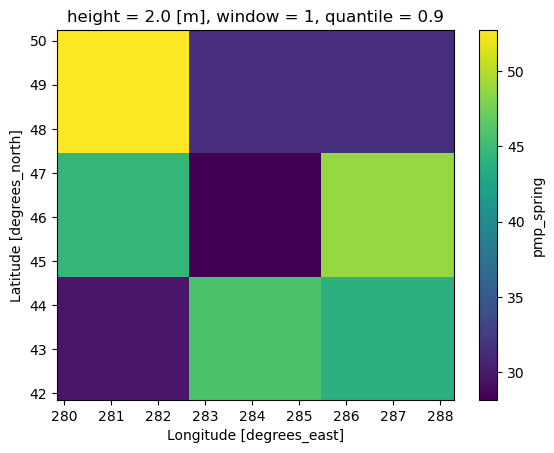

In [10]:
pmp_spring.sel(window=1).plot()

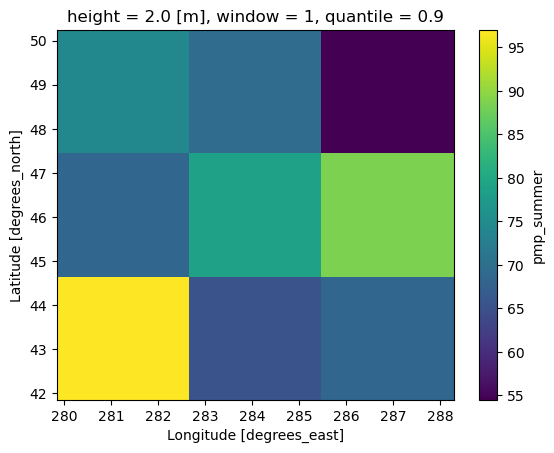

In [11]:
pmp_summer.sel(window=1).plot()

## 2. PMP with aggregated storm configurations

The spatial_average_storm_configurations function allows to spatially aggregate the storms following the different configurations shown in Clavet-Gaumont et al. (2017). Once the variables rf, pw, snw are aggregated, the calculation of the PMP follows the same steps shown above.

In [12]:
radius = 3  # Maximum radius of the storm.

ds_day_agg = (
    pmp.spatial_average_storm_configurations(ds_day.rf, radius)
    .chunk(dict(time=-1))
    .compute()
)
pe_agg = pmp.major_precipitation_events(
    ds_day_agg.chunk(dict(conf=-1)), windows=[1], quantile=0.9
).compute()

# Precipitable water (pw) must first be calculated in a distributed manner and then spatially averaged to obtain the aggregated precipitable water.
pw_agg = pmp.spatial_average_storm_configurations(pw, radius).compute()

pw_events_agg = pw_agg.where(pe_agg > 0)

pw100_agg = pmp.precipitable_water_100y(
    pw_agg.sel(window=1).chunk(dict(time=-1)), dist="genextreme", method="ML", mf=0.2
).compute()

r_agg = pw100_agg / pw_events_agg

pmax_agg = r_agg * pe_agg

# To create the spring and summer masks, the snow cover must first be spatially averaged (ds_snw_agg).
ds_snw_agg = (
    pmp.spatial_average_storm_configurations(ds_day.snw, radius)
    .chunk(dict(time=-1))
    .compute()
)

mask_agg = pmp.compute_spring_and_summer_mask(
    ds_snw_agg.isel(
        y=slice(0, -1), x=slice(0, -1)
    ),  # Cut the domain because the aggregation creates NaN
    thresh="1 cm",
    window_wint_start=14,
    window_wint_end=14,
    spr_start=60,
    spr_end=30,
    freq="YS-SEP",
).compute()

pmax_agg_cut = pmax_agg.isel(y=slice(0, -1), x=slice(0, -1))

pmax_spring_agg = (pmax_agg_cut * mask_agg.mask_spring).rename("pmp_spring")
pmax_summer_agg = (pmax_agg_cut * mask_agg.mask_summer).rename("pmp_summer")

### 2.1. PMP results

The results of the PMP at y=46.04, x= 284.06 for different storm configurations are shown below.

In [13]:
pmp_spring_agg = pmax_spring_agg.max("time")
pmp_summer_agg = pmax_summer_agg.max("time")

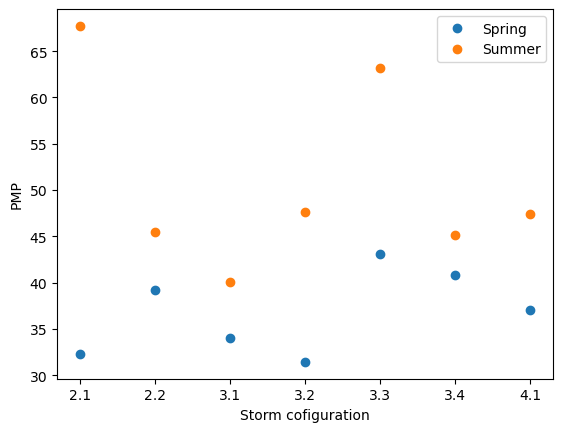

In [14]:
sp_agg = pmp_spring_agg.sel(window=1, y=46.04, x=284.06)
sm_agg = pmp_summer_agg.sel(window=1, y=46.04, x=284.06)

plt.plot(np.arange(len(sp_agg)), sp_agg.values, "o", label="Spring")
plt.plot(np.arange(len(sm_agg)), sm_agg.values, "o", label="Summer")
plt.xticks(ticks=np.arange(len(sp_agg)), labels=sp_agg.conf.values)
plt.ylabel("PMP")
plt.xlabel("Storm cofiguration")
plt.legend()